In [1]:
%matplotlib inline

## Imports

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

## Load the data file
(as preprocessed by @mkarmona)

In [3]:
pg = pd.read_csv('postgap_20180108_gwas_filtered.tsv.gz', sep='\t', na_values=['None'])
print(pg.shape)
pg.head()

/Users/gpeat/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,3,12,14,25,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(27371281, 47)


,ld_snp_rsID,chrom,pos,GRCh38_chrom,GRCh38_pos,afr_maf,amr_maf,eas_maf,eur_maf,sas_maf,...,VEP,Fantom5,DHS,PCHiC,Nearest,Regulome,VEP_reg,vep_max_score,fg_score,snp_gene_dist
0,rs73726893,6,32548069,CHR_HSCHR6_MHC_QBL_CTG1,32514581,0.0764,0.0965,0.0982,0.0726,0.0317,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.5,2147483647
1,rs138816958,6,32598798,CHR_HSCHR6_MHC_QBL_CTG1,32564464,0.1195,0.0965,0.1161,0.0676,0.0706,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.5,2147483647
2,rs76391884,6,32604085,CHR_HSCHR6_MHC_SSTO_CTG1,32729701,0.0991,0.0764,0.1002,0.0517,0.0644,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.5,2147483647
3,rs192376296,6,32577467,CHR_HSCHR6_MHC_SSTO_CTG1,32703238,0.0000,0.0058,0.0010,0.0457,0.0031,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.5,2147483647
4,rs115290336,6,32605107,CHR_HSCHR6_MHC_SSTO_CTG1,32730726,0.1059,0.0865,0.1032,0.0596,0.0654,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.5,2147483647


## Datamodel
POSTGAP data has many columns of data, but the unique key is `(ld_snp_rsID, gwas_snp, gene_id, disease_efo_id, gwas_pmid)`.

**Question**: Is this combination indeed unique?

In [4]:
primary_key = ['ld_snp_rsID', 'gwas_snp', 'gene_id', 'disease_efo_id', 'gwas_pmid']
primary_key_groups = pg.groupby(primary_key)
primary_key_group_sizes = primary_key_groups.size()
primary_key_groups_non_unique = primary_key_group_sizes[primary_key_group_sizes > 1]
# if the primary_key is unique, then primary_key_groups_non_unique should be empty
print(primary_key_groups_non_unique.shape)
primary_key_groups_non_unique.sort_values(ascending=False).head()

(2997328,)


ld_snp_rsID  gwas_snp   gene_id          disease_efo_id  gwas_pmid   
rs4722529    rs1055144  ENSG00000086300  EFO_0008002     PMID28448500    25
rs6461887    rs1055144  ENSG00000105954  EFO_0008002     PMID28448500    25
rs10260677   rs1055144  ENSG00000070882  EFO_0008002     PMID28448500    25
                        ENSG00000005073  EFO_0008002     PMID28448500    25
rs3902751    rs1055144  ENSG00000153790  EFO_0008002     PMID28448500    25
dtype: int64

**Question**: Is POSTGAP score unique for (`ld_snp_rsID`, `gene_id`)?

In [5]:
gene_snp_groups = pg.groupby(['ld_snp_rsID', 'gene_id'])
score_sizes = gene_snp_groups['score'].nunique()
non_unique_scores_per_gene_snp_group = score_sizes[score_sizes > 1]
non_unique_scores_per_gene_snp_group.shape

(789,)

**Question**: How many unique `primary keys` (as defined above) are there?

In [6]:
print(primary_key_group_sizes.shape)

(22123646,)


**Question**: How many unique `(ld_snp_rsID, gene_id, disease_efo_id, gwas_pmid)` sets are there? (ie. `primary key` above without `gwas_snp`)?

In [7]:
other_key = ['ld_snp_rsID', 'gene_id', 'disease_efo_id', 'gwas_pmid']
other_key_groups = pg.groupby(other_key)
other_key_group_sizes = other_key_groups.size()
print(other_key_group_sizes.shape)

(18167696,)


**Question**: How many unique `(gwas_snp, gene_id, disease_efo_id, gwas_pmid)` sets are there? (ie. `primary key` above without `ld_snp_rsID`)?

In [8]:
other_key = ['gwas_snp', 'gene_id', 'disease_efo_id', 'gwas_pmid']
other_key_groups = pg.groupby(other_key)
other_key_group_sizes = other_key_groups.size()
print(other_key_group_sizes.shape)

(789365,)


**Question**: How many unique `(gwas_snp, disease_efo_id, gwas_pmid)` sets are there?

In [9]:
key = ['gwas_snp', 'disease_efo_id', 'gwas_pmid']
key_groups = pg.groupby(key)
key_group_sizes = key_groups.size()
print(key_group_sizes.shape)

(43941,)


**Question**: Is the POSTGAP score unique by the primary key described above?

In [10]:
score_counts_per_primary_key_group = primary_key_groups['score'].nunique()
print(score_counts_per_primary_key_group[score_counts_per_primary_key_group > 1])

Series([], Name: score, dtype: int64)


**Question**: What is the distribution of target counts per `('gwas_snp', 'disease_efo_id', 'gwas_pmid')` set?

In [11]:
target_counts_for_key_groups = key_groups['gene_id'].nunique()

In [12]:
target_counts = target_counts_for_key_groups.reset_index(level=['gwas_snp', 'disease_efo_id', 'gwas_pmid']).rename(columns={'gene_id': 'target_count_per_key'})
target_counts.head()

,gwas_snp,disease_efo_id,gwas_pmid,target_count_per_key
0,rs1000005,EFO_0007991,PMID27863252,21
1,rs10000225,GO_0097366,PMID26634245,7
2,rs1000083,EFO_0006951,PMID28039263,8
3,rs1000083,GO_0072718,PMID28039263,8
4,rs10004195,EFO_0005247,PMID23652523,17


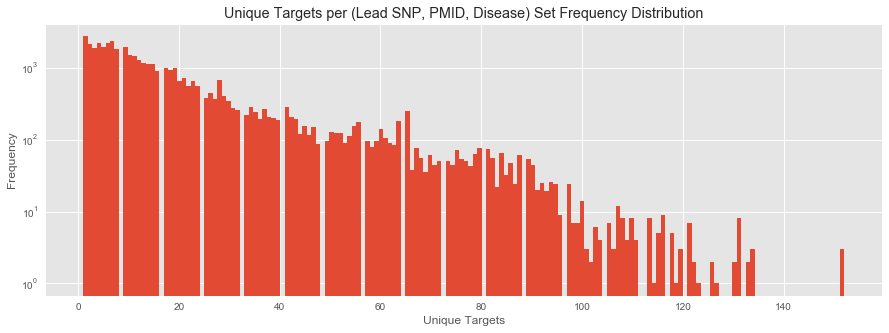

In [13]:
plt.figure(figsize=(15, 5))
plt.hist(target_counts_for_key_groups, bins=170, log=True)
plt.title('Unique Targets per (Lead SNP, PMID, Disease) Set Frequency Distribution')
plt.xlabel('Unique Targets')
plt.ylabel('Frequency')
plt.show()

**Question**: What is the distribution of POSTGAP scores per `('ld_snp_rsID', 'gwas_snp', 'gene_id', 'disease_efo_id', 'gwas_pmid')` set?

In [14]:
scores_per_primary_key_group = primary_key_groups['score'].first() # ignore exceptions to uniqueness found above

In [15]:
scores = scores_per_primary_key_group.reset_index(level=['gwas_snp', 'disease_efo_id', 'gwas_pmid', 'ld_snp_rsID', 'gene_id'])
scores.head()

,ld_snp_rsID,gwas_snp,gene_id,disease_efo_id,gwas_pmid,score
0,rs10000021,rs936094,ENSG00000052795,EFO_0000220,PMID22076464,0.492369
1,rs10000021,rs936094,ENSG00000109756,EFO_0000220,PMID22076464,0.324204
2,rs10000021,rs936094,ENSG00000164123,EFO_0000220,PMID22076464,0.564575
3,rs10000021,rs936094,ENSG00000164124,EFO_0000220,PMID22076464,0.995720
4,rs10000021,rs936094,ENSG00000164125,EFO_0000220,PMID22076464,0.546565


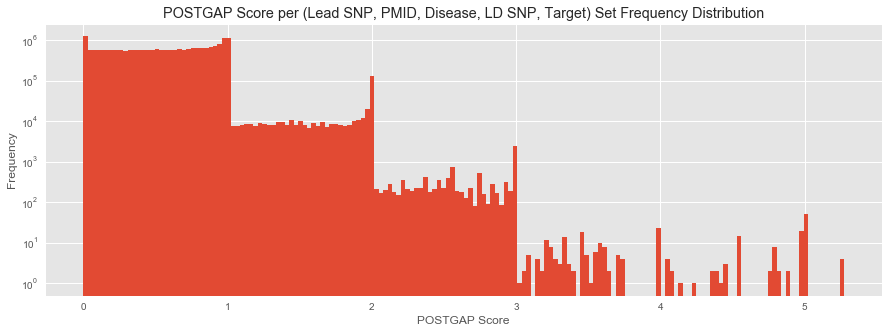

In [16]:
primary_key_groups['score']
plt.figure(figsize=(15, 5))
plt.hist(scores_per_primary_key_group, bins=170, log=True)
plt.title('POSTGAP Score per (Lead SNP, PMID, Disease, LD SNP, Target) Set Frequency Distribution')
plt.xlabel('POSTGAP Score')
plt.ylabel('Frequency')
plt.show()

**Question**: What is the combined distribution of the above two distributions?

In [17]:
combi_dist = pd.merge(target_counts, scores, on=('gwas_snp', 'disease_efo_id', 'gwas_pmid'))
combi_dist.head()

,gwas_snp,disease_efo_id,gwas_pmid,target_count_per_key,ld_snp_rsID,gene_id,score
0,rs1000005,EFO_0007991,PMID27863252,21,rs1000005,ENSG00000142166,0.885208
1,rs1000005,EFO_0007991,PMID27863252,21,rs1000005,ENSG00000142188,0.115687
2,rs1000005,EFO_0007991,PMID27863252,21,rs1000005,ENSG00000142207,0.578838
3,rs1000005,EFO_0007991,PMID27863252,21,rs1000005,ENSG00000159055,0.964344
4,rs1000005,EFO_0007991,PMID27863252,21,rs1000005,ENSG00000159082,0.807707


In [18]:
combi_dist['score'] = combi_dist['score'].apply(lambda x: np.floor(x * 10) / 10)

In [19]:
grid = pd.crosstab(combi_dist['score'], combi_dist['target_count_per_key'])
grid.head()

target_count_per_key,1,2,3,4,5,6,7,8,9,10,...,121,122,123,126,127,130,131,133,134,152
score,,,,,,,,,,,,,,,,,,,,,
0.0,3529,7290,9819,14634,21068,35875,39590,34255,35688,34733,...,7083,1115,613,2156,1021,542,6432,1921,1341,588
0.1,2223,4968,8931,11301,14176,22883,34809,27614,28926,23874,...,4967,758,151,643,168,286,2038,790,228,357
0.2,2674,5064,10137,18497,15349,20258,31565,30486,28192,25077,...,4208,834,214,576,151,372,2490,926,222,492
0.3,2681,5552,8894,17307,15483,22531,37438,26566,26102,24939,...,4922,1192,236,872,146,379,1856,1026,189,396
0.4,2475,4869,8541,14443,16220,24299,43257,25746,26839,24966,...,4316,1335,342,982,155,398,2056,956,231,258


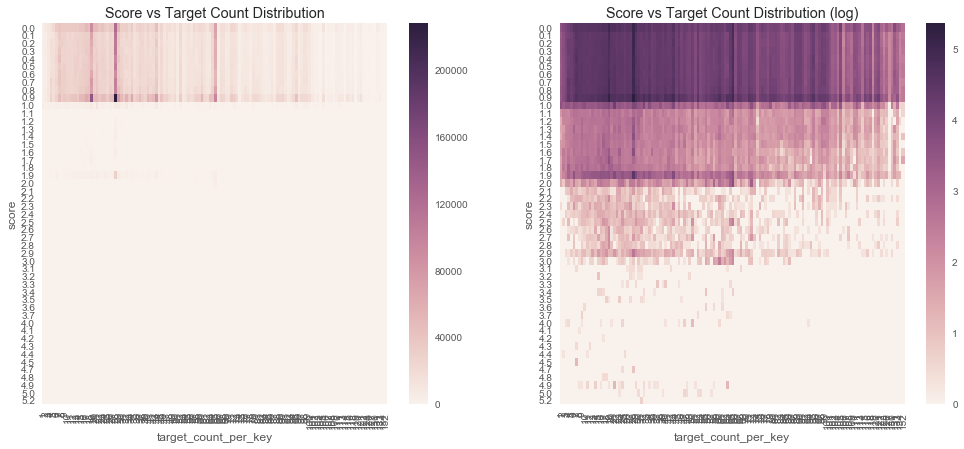

In [20]:
plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)
sns.heatmap(grid)
plt.title('Score vs Target Count Distribution')

plt.subplot(1, 2, 2)
sns.heatmap(grid.apply(lambda x: np.log10(x + 1)))
plt.title('Score vs Target Count Distribution (log)')
plt.show()

**Question**: How many unique `ld_snp_rsID` values are there? How about the other elements of the unique key?

In [21]:
print('Genes: {}'.format(pg['gene_id'].nunique()))
print('LD SNPs: {}'.format(pg['ld_snp_rsID'].nunique()))
print('GWAS SNPs: {}'.format(pg['gwas_snp'].nunique()))
print('Diseases: {}'.format(pg['disease_efo_id'].nunique()))
print('GWAS PubMed IDs: {}'.format(pg['gwas_pmid'].nunique()))

Genes: 17833
LD SNPs: 524358
GWAS SNPs: 28924
Diseases: 1713
GWAS PubMed IDs: 2047


**Question**: How frequently does each unique `ld_snp_rsID` appear across all rows? How about the other elements of the unique key?

ld_snp_rsID
rs174562     15720
rs1535       15720
rs174574     15677
rs5792235    15196
rs174554     15196
dtype: int64
gwas_snp
rs174547     153450
rs3177928    139218
rs6772896    101790
rs102275      91729
rs9268923     84819
dtype: int64
gene_id
ENSG00000136378    67929
ENSG00000140395    67852
ENSG00000140403    67120
ENSG00000166557    67003
ENSG00000166411    66876
dtype: int64
disease_efo_id
GO_0097366     2023825
EFO_0008002    1144782
EFO_0000692    1055791
EFO_0004713     966314
EFO_0007789     721211
dtype: int64
gwas_pmid
PMID26634245    2997326
PMID27863252    2528173
PMID28448500    1845390
PMID25673412     587203
PMID27790247     481771
dtype: int64


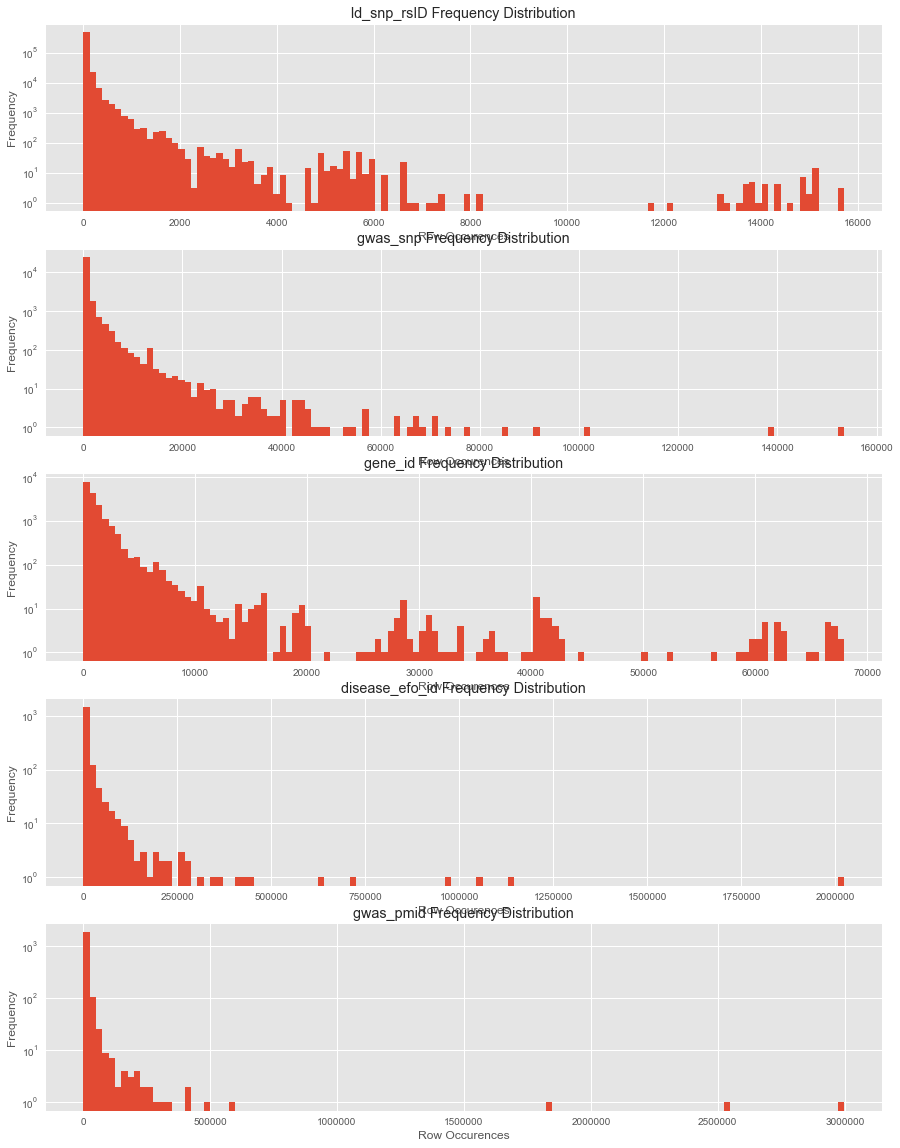

In [22]:
plt.figure(figsize=(15, 20))

for (i, c) in enumerate(primary_key):
    groups = pg.groupby(c)
    group_frequencies = groups.size()

    plt.subplot(5, 1, i + 1)
    plt.hist(group_frequencies, bins=120, log=True)
    plt.title('{} Frequency Distribution'.format(c))
    plt.xlabel('Row Occurences')
    plt.ylabel('Frequency')
    
    print(group_frequencies.sort_values(ascending=False).head())

plt.show()

**Question**: How many unique `(ld_snp_rsID, gwas_snp)` pairs are there? How about other pairwise combinations of the unique key (there are 5C2=10 of them)?

In [23]:
import itertools

pairs = itertools.combinations(primary_key, 2)
for (i, c) in enumerate(pairs):
    print('{} unique pairs: {}'.format(c, len(pg.groupby(c).size())))

('ld_snp_rsID', 'gwas_snp') unique pairs: 896384
('ld_snp_rsID', 'gene_id') unique pairs: 7656139
('ld_snp_rsID', 'disease_efo_id') unique pairs: 942230
('ld_snp_rsID', 'gwas_pmid') unique pairs: 814862
('gwas_snp', 'gene_id') unique pairs: 506097
('gwas_snp', 'disease_efo_id') unique pairs: 41982
('gwas_snp', 'gwas_pmid') unique pairs: 32418
('gene_id', 'disease_efo_id') unique pairs: 465628
('gene_id', 'gwas_pmid') unique pairs: 388254
('disease_efo_id', 'gwas_pmid') unique pairs: 3698


**Question**: How frequestly does each `(ld_snp_rsID, gwas_snp)` pair occur across all rows? How about other pairwise combinations of the unique key (there are 5C2=10 of them)?

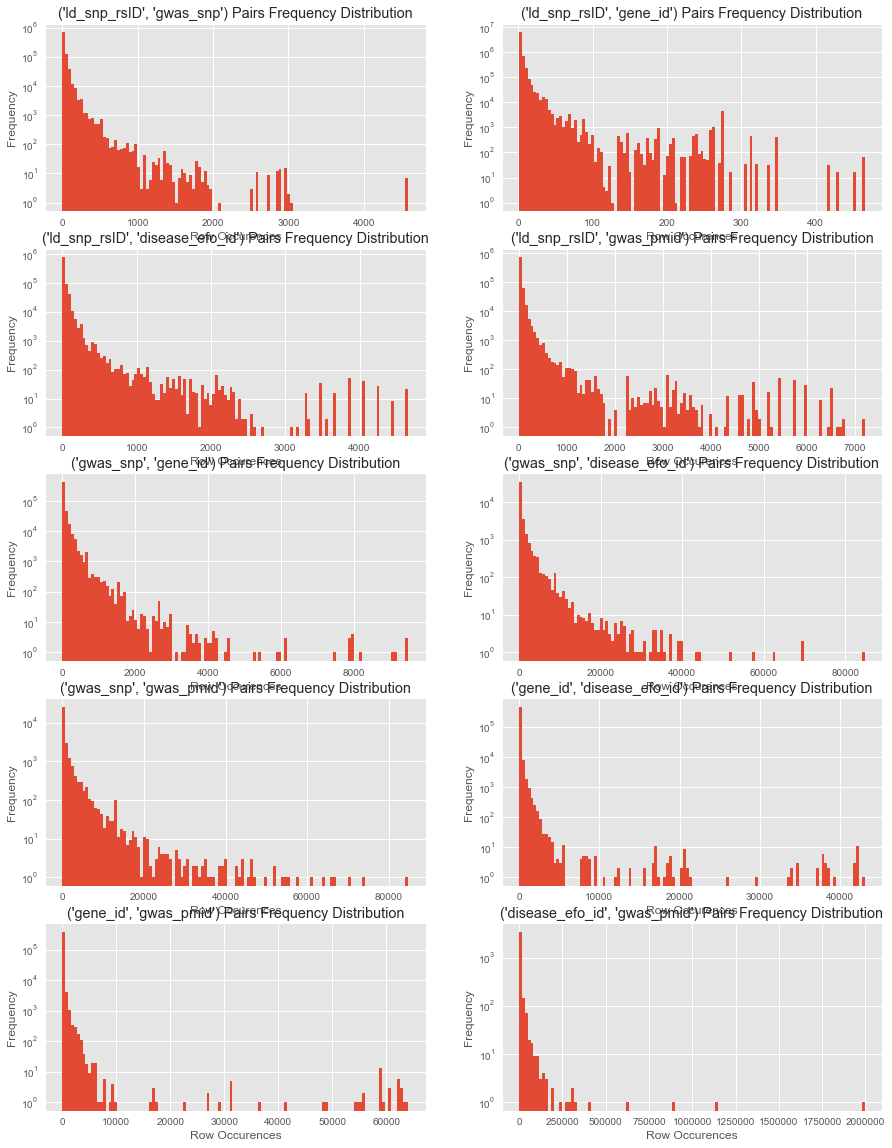

In [24]:
plt.figure(figsize=(15, 20))

pairs = itertools.combinations(primary_key, 2)
for (i, c) in enumerate(pairs):
    connections = pg.groupby(c)
    connection_frequencies = connections.size()

    plt.subplot(5, 2, i + 1)
    plt.hist(connection_frequencies, bins=120, log=True)
    plt.title('{} Pairs Frequency Distribution'.format(c))
    plt.xlabel('Row Occurences')
    plt.ylabel('Frequency')

plt.show()

### Score, r2 and GWAS p-value
Of the above pairs, three have an associated strength, as below.

| Strength measure | Pair | Range |
| -- | -- | -- |
| score | ('ld_snp_rsID', 'gene_id') | [0, 38] |
| r2 | ('ld_snp_rsID', 'gwas_snp') | [0.7, 1.0] |
| gwas_pvalue | ('gwas_snp', 'disease_efo_id') | [0, 1] |

The distribution can be given across all rows *OR* across all unique pairs (as in the table). Both are displayed below, for each strength measure.

**Question**: How is the POSTGAP score distributed?

In [25]:
def plot_strength_distribution(connection_strength_all, connection_strength_no_dupes, label):
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.hist(connection_strength_all.values.flatten(), bins=100, log=True)
    plt.title('{} Distribution'.format(label))
    plt.ylabel('Frequency')
    plt.xlabel('Value')

    plt.subplot(122)
    plt.hist(connection_strength_no_dupes.values.flatten(), bins=100, log=True)
    plt.title('{} Distribution (no duplicate pairs)'.format(label))
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    plt.show()

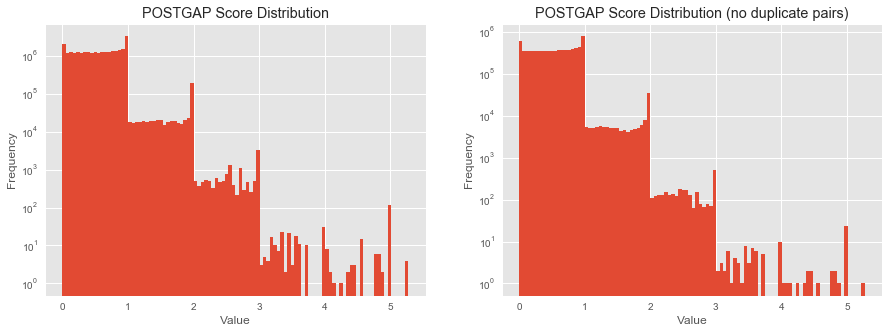

In [26]:
score_all = pg['score']
# TODO: Check score is the same across all (gene_id, ld_snp_rsID) pairs (to justify use of first())
score_no_dupes = pg.groupby(['gene_id', 'ld_snp_rsID'])['score'].first()
plot_strength_distribution(score_all, score_no_dupes, 'POSTGAP Score')

**Question**: How is the `r2` value distributed?

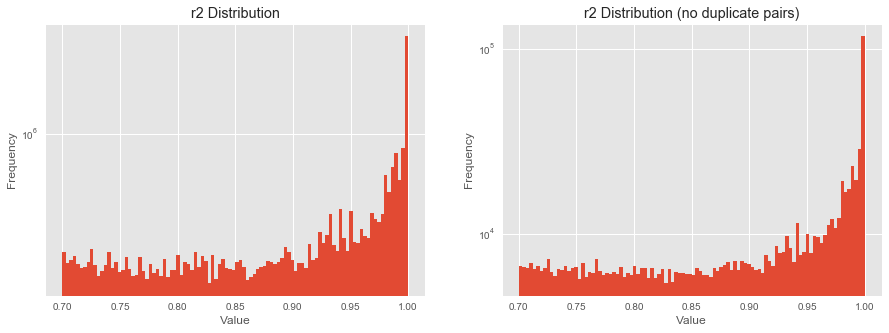

In [27]:
r2_all = pg['r2']
r2_no_dupes = pg.groupby(['ld_snp_rsID', 'gwas_snp'])['r2'].first()
plot_strength_distribution(r2_all, r2_no_dupes, 'r2')
# note: r2 col appears to contain r, not r2

In [28]:
pg[pg.r2 < 0].head()

,ld_snp_rsID,chrom,pos,GRCh38_chrom,GRCh38_pos,afr_maf,amr_maf,eas_maf,eur_maf,sas_maf,...,VEP,Fantom5,DHS,PCHiC,Nearest,Regulome,VEP_reg,vep_max_score,fg_score,snp_gene_dist


**Question**: How is the `gwas_pvalue` distributed?

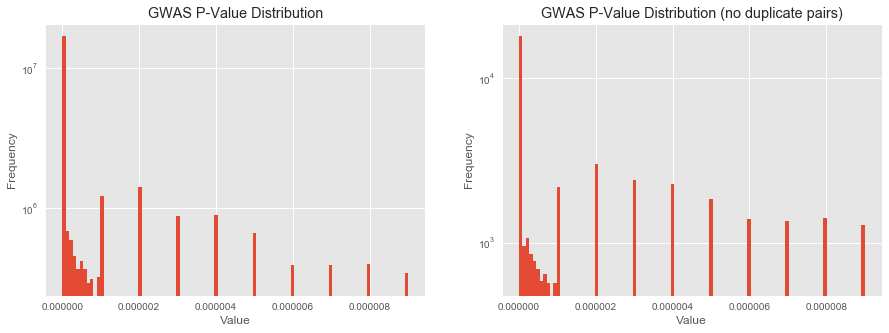

In [29]:
pval_all = pg['gwas_pvalue']
# TODO: check if the grouping should include pmid for uniqueness of first()
pval_no_dupes = pg.groupby(['gwas_snp', 'disease_efo_id'])['gwas_pvalue'].first()
plot_strength_distribution(pval_all, pval_no_dupes, 'GWAS P-Value')

## Connection degree distribution
One key aspect of the POSTGAP data model is the clusters of `ld_snp`s per `lead_snp`. We could ask the following questions:

**Question**: If a given `ld_snp` is chosen, how many unique `lead_snp`s is it linked to?

**Question**: If a given `lead_snp` is chosen, how many unique `ld_snp`s is it linked to?

In [30]:
def plot_connection_degree_distribution(a_degrees, b_degrees, a_label, b_label):
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.hist(a_degrees.values.flatten(), bins=100, log=True)
    plt.title('{}s per {} Distribution'.format(b_label, a_label))
    plt.ylabel('Frequency')
    plt.xlabel('Degree')

    plt.subplot(122)
    plt.hist(b_degrees.values.flatten(), bins=100, log=True)
    plt.title('{}s per {} Distribution'.format(a_label, b_label))
    plt.ylabel('Frequency')
    plt.xlabel('Degree')
    plt.show()

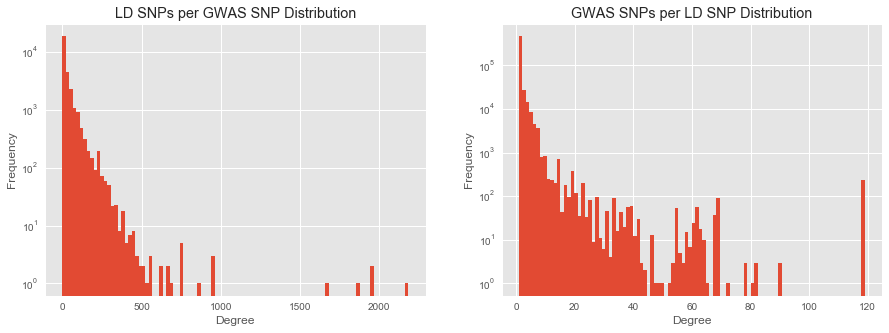

In [31]:
# Note: use count() to include row repeats, or nunique() to skip repeats
ld_snps_per_lead_snp = pg.groupby('gwas_snp')['ld_snp_rsID'].nunique()
lead_snps_per_ld_snp = pg.groupby('ld_snp_rsID')['gwas_snp'].nunique()
plot_connection_degree_distribution(ld_snps_per_lead_snp, lead_snps_per_ld_snp, 'GWAS SNP', 'LD SNP')

Similarly:
    
**Question**: If a given `gene` is chosen, how many `ld_snp`s is it linked to?
    
**Question**: If a given `ld_snp` is chosen, how many `gene`s is it linked to?

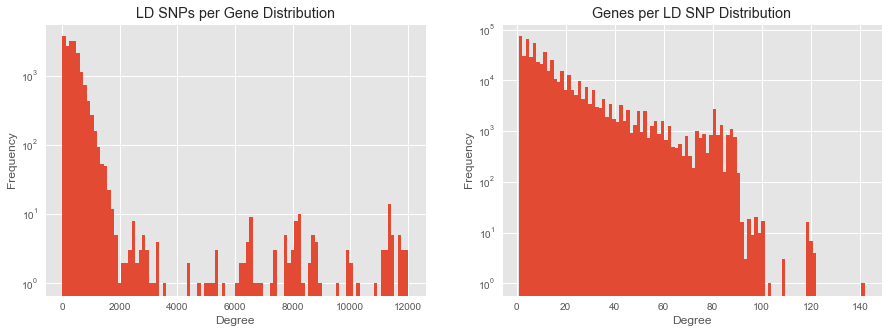

In [32]:
ld_snps_per_gene = pg.groupby('gene_id')['ld_snp_rsID'].nunique()
genes_per_ld_snp = pg.groupby('ld_snp_rsID')['gene_id'].nunique()
plot_connection_degree_distribution(ld_snps_per_gene, genes_per_ld_snp, 'Gene', 'LD SNP')

Similarly:

**Question**: If a given `lead_snp` is chosen, how many `disease`s is it linked to?

**Question**: If a given `disease` is chosen, how many `lead_snp`s is it linked to?

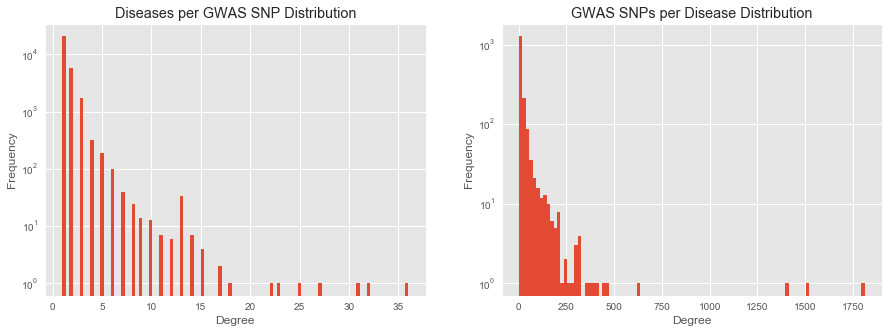

In [33]:
diseases_per_lead_snp = pg.groupby('gwas_snp')['disease_efo_id'].nunique()
lead_snps_per_disease = pg.groupby('disease_efo_id')['gwas_snp'].nunique()
plot_connection_degree_distribution(diseases_per_lead_snp, lead_snps_per_disease, 'GWAS SNP', 'Disease')

## Clusters and their windows
From the perspective of the planned visualisation, clusters of `ld_snp`s might be indexed by:
* A: `gwas_snp` (ie. lumping all genes/diseases in; perhaps not as useful, **but** original test slices of this format)
* B: `gwas_snp, gene_id` (ie. lumping all diseases in; perhaps useful on target profile page)
* C: `gwas_snp, disease_efo_id` (ie. lumping all genes in; perhaps useful on disease profile page)
* D: `gwas_snp, gene_id, disease_efo_id` (ie. as specific as possible; perhaps useful on the evidence page)

**Question**: Under each cluster indexing scheme, how many unique `ld_snp`s are there per cluster? 

**Question**: Under each cluster indexing scheme, what is the base pair window size of the `ld_snp`s? 

In [34]:
set_a = ['gwas_snp']
set_b = ['gwas_snp', 'gene_id']
set_c = ['gwas_snp', 'disease_efo_id']
set_d = ['gwas_snp', 'gene_id', 'disease_efo_id']

In [35]:
def plot_cluster_scheme_summary(key_set):
    clusters = pg[[*key_set, 'ld_snp_rsID', 'pos', 'chrom']].drop_duplicates().groupby(key_set)
    cluster_sizes = clusters['ld_snp_rsID'].nunique() # again the nunique/count distinction
    
    sorted_sizes = cluster_sizes.sort_values().values
    smallest = sorted_sizes[0]
    largest = sorted_sizes[-1]
    
    cluster_windows = clusters['pos'].agg([np.min, np.max])
    
    # TODO: currently cluster_window_sizes contains dupes (by ld_snp_rsID) that cluster_sizes removes with nunique()
    #       how to remove?
    cluster_window_sizes = cluster_windows.T.apply(lambda x: x['amax'] - x['amin'])
    sorted_window_sizes = cluster_window_sizes.sort_values().values
    narrowest = sorted_window_sizes[0]
    widest = sorted_window_sizes[-1]
    
    print('Clustering by {}'.format(key_set))
    print('Number of clusters: {}'.format(len(cluster_sizes)))
    print('Smallest {};  Largest {}'.format(smallest, largest))
    print('Narrowest {};  Widest {}'.format(narrowest, widest))
    
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.hist(cluster_sizes, bins=50, log=True)
    plt.title('Cluster Size Distribution\n(by {})'.format(key_set))
    plt.ylabel('Frequency')
    plt.xlabel('Size')

    plt.subplot(122)
    plt.hist(cluster_window_sizes, bins=50, log=True)
    plt.title('Cluster Window Range Distribution\n(by {})'.format(key_set))
    plt.ylabel('Frequency')
    plt.xlabel('Range (bp)')
    plt.show()

Clustering by ['gwas_snp']
Number of clusters: 28924
Smallest 1;  Largest 2183
Narrowest 0;  Widest 1900882


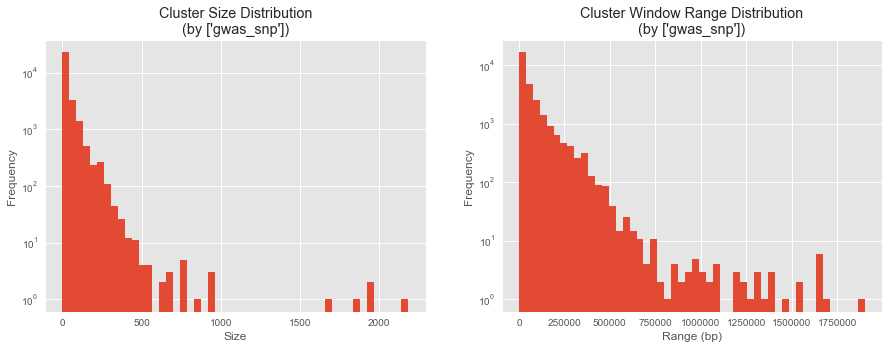

Clustering by ['gwas_snp', 'gene_id']
Number of clusters: 506097
Smallest 1;  Largest 2037
Narrowest 0;  Widest 1889642


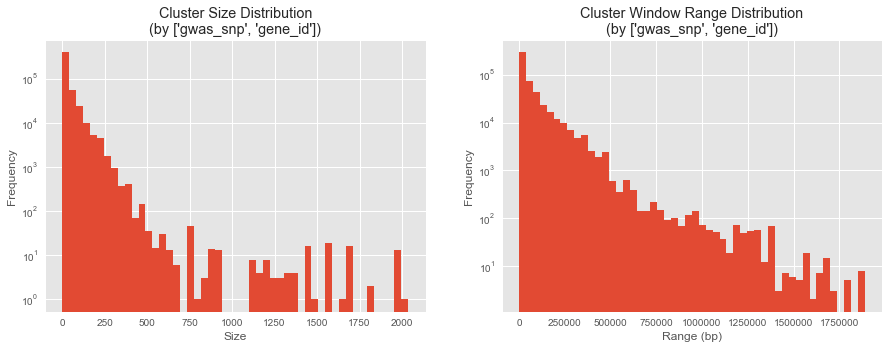

Clustering by ['gwas_snp', 'disease_efo_id']
Number of clusters: 41982
Smallest 1;  Largest 2183
Narrowest 0;  Widest 1691915


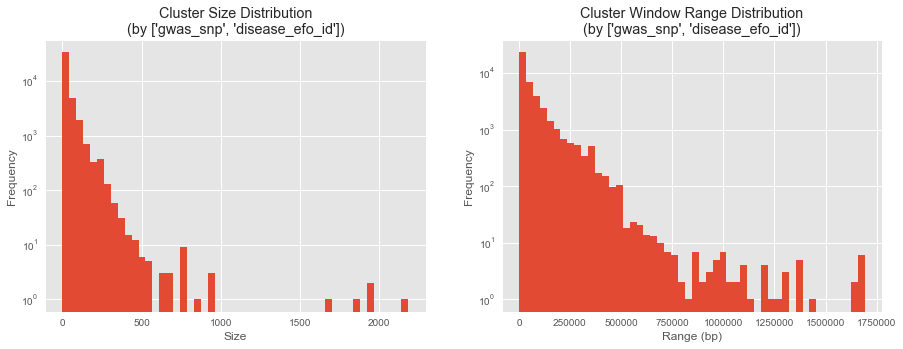

Clustering by ['gwas_snp', 'gene_id', 'disease_efo_id']
Number of clusters: 742588
Smallest 1;  Largest 2037
Narrowest 0;  Widest 1691915


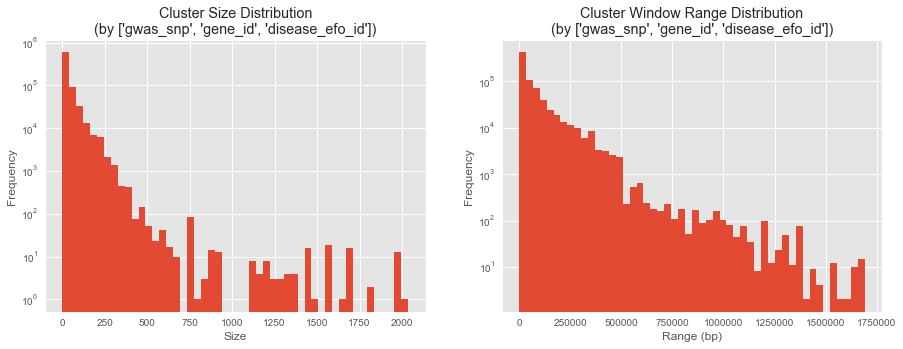

In [36]:
plot_cluster_scheme_summary(set_a)
plot_cluster_scheme_summary(set_b)
plot_cluster_scheme_summary(set_c)
plot_cluster_scheme_summary(set_d)

**Question**: Does the LD SNP chromosome always match the gene chromosome?

In [37]:
rows_different_chroms = pg[pg.chrom != pg.gene_chrom]
rows_different_chroms[['ld_snp_rsID', 'gene_symbol', 'chrom', 'gene_chrom']].groupby(['chrom', 'gene_chrom']).first()

ld_snp_rsID    gene_symbol
chrom gene_chrom                            
1     3            rs10875073          TFDP2
      6            rs11205277            HFE
      10          rs554523047          FANK1
      16          rs374960993          SF3B3
      17          rs554523047           WSB1
      18            rs1167998         MYL12A
      1            rs10803231         LGALS8
2     3            rs12622393         P2RY14
      6             rs9283487       HLA-DQA2
      9           rs535864343          DDX31
      10           rs17009149           ATE1
      11           rs72961173         OR10A5
      12           rs77120043        SLC6A12
      15           rs11126956       C15orf57
      16           rs10205592            GP2
      17            rs2160232          OR1G1
      18           rs12618567          SOGA2
      10           rs16845747          DHX32
      2            rs58430496           ATIC
      X            rs16845747          VAMP7
3     1             rs6777467          RWDD3
      4             rs2143817          ABCG2
      6            rs11359982        C6orf89
      3            rs77496824          RSRC1
4     8            rs28374205         DENND3
      12          rs200215281  CTD-2140B24.4
      13           rs71200368          IFT88
      14          rs113228472         DNAAF2
      21            rs1494950         ADARB1
      22            rs9918077          LIMK2
...                       ...            ...
1     16            rs7549396          SF3B3
      6             rs1061955       HIST1H4C
10    2           rs115998322         HPCAL1
      5           rs200355261          CHSY3
11    17             rs939916         RNMTL1
      19           rs11245998           MZF1
      2           rs141402489        EIF2AK2
12    15           rs78785548         FAM98B
15    6            rs57310185          QRSL1
      9             rs2927070            GDA
16    1              rs195656         PRKAB2
17    1            rs11079645         CLCNKA
19    12           rs10412465          ZNF10
2     10          rs201447374          FANK1
      17            rs2160232          OR1G1
22    9           rs117744580         GABBR2
3     1             rs6777467          RWDD3
      4             rs6439432        ADAMTS3
      6            rs61032856           AGER
4     10           rs11132733          FANK1
      12          rs200215281         ZNF268
      19            rs2883229         ZNF135
      X             rs2859208           IL9R
5     13           rs76811681         SLAIN1
      18            rs6894268          RBBP8
6     1            rs16891484      HIST2H2BE
      2             rs9270299         SH3BP4
7     1            rs75119251          ITPKB
      2            rs74446409            TTL
9     6            rs58960269        MRPS18A

[141 rows x 2 columns]

**Question**: How many unique `['ld_snp_rsID', 'gene_symbol']` pairs per `['chrom', 'gene_chrom']` pair?

In [38]:
rows_different_chroms[['ld_snp_rsID', 'gene_symbol', 'chrom', 'gene_chrom']].drop_duplicates().groupby(['chrom', 'gene_chrom']).size()

chrom  gene_chrom
1      3                2
       6                2
       10               2
       16               4
       17              17
       18               4
       1             2374
2      3               14
       6                9
       9                2
       10              31
       11               2
       12               1
       15              11
       16               1
       17              15
       18               1
       10               5
       2             4831
       X                1
3      1                2
       4               14
       6               49
       3             4311
4      8                3
       12               4
       13               2
       14               1
       21               1
       22               1
                     ... 
1      16               2
       6                1
10     2               12
       5                2
11     17              20
       19              29
       2            

**Question**: How does POSTGAP score vary with distance (of LD SNP to gene TSS)?

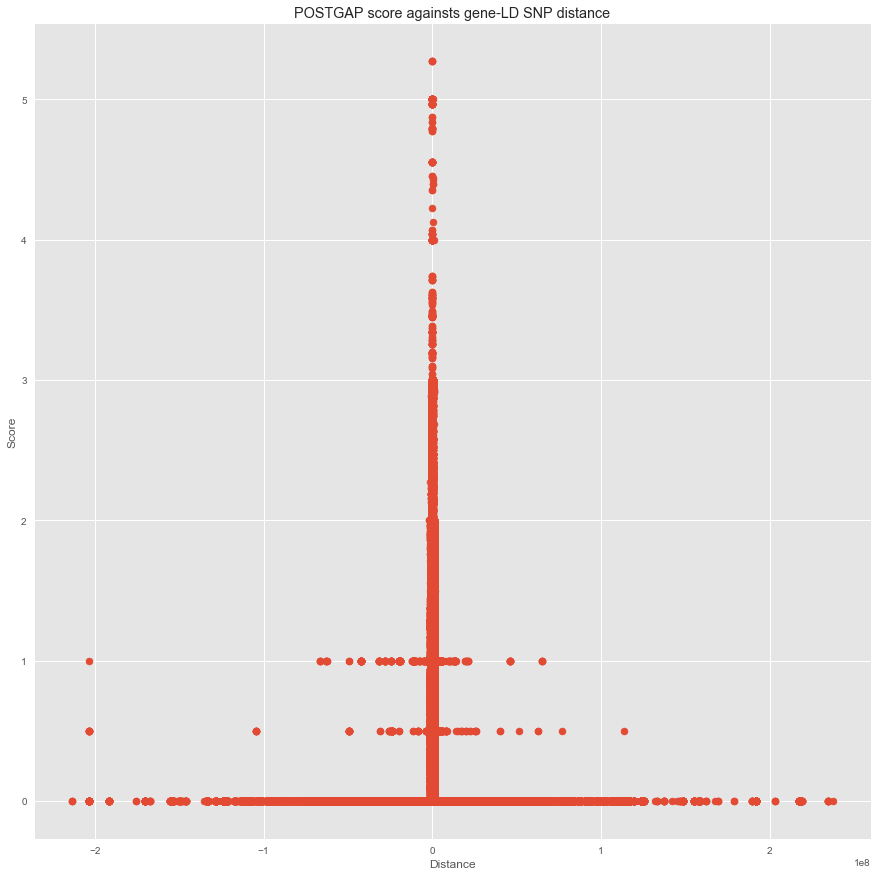

In [39]:
dists = pg.pos - pg.gene_tss
plt.figure(figsize=(15, 15))
plt.scatter(dists, pg.score)
plt.title('POSTGAP score againsts gene-LD SNP distance')
plt.ylabel('Score')
plt.xlabel('Distance')
plt.show()

**Question**: Which chromosomes are listed? Will the non-standard ones be a problem for visualisation?

In [40]:
pg.chrom.unique()

array([6, 20, 1, 7, 4, 3, 10, 2, 8, 21, 13, 15, 5, 9, 16, 19, 14, 11, 17,
       12, 18, 22, '1', '2', '3', '6', '11', '16', '17', '10', '19', '7',
       '8', '4', '12', '9', '13', '22', 'X', '20', '18', '15', '5', '14',
       '21'], dtype=object)

In [41]:
pg.GRCh38_chrom.unique()

array(['CHR_HSCHR6_MHC_QBL_CTG1', 'CHR_HSCHR6_MHC_SSTO_CTG1', '20', '6',
       '1', '7', '4', '3', 'CHR_HSCHR6_8_CTG1', '10', '2', '8', '21', '13',
       '15', '5', '9', '16', 'CHR_HG2030_PATCH', '19', '14', '11', '17',
       'CHR_HG2072_PATCH', '12', 'CHR_HSCHR5_4_CTG1',
       'CHR_HSCHR19_4_CTG3_1', '18', '22', 'CHR_HG2104_PATCH',
       'CHR_HSCHR11_2_CTG1_1', 'CHR_HSCHR15_2_CTG8',
       'CHR_HSCHR19KIR_FH08_A_HAP_CTG3_1',
       'CHR_HSCHR19KIR_FH15_A_HAP_CTG3_1', 'CHR_HG2191_PATCH',
       'CHR_HSCHR8_1_CTG7', 'CHR_HSCHR19LRC_PGF1_CTG3_1',
       'CHR_HSCHR19LRC_COX2_CTG3_1', 'CHR_HSCHR17_7_CTG4',
       'CHR_HG2066_PATCH', 'CHR_HSCHR17_10_CTG4', 'CHR_HSCHR22_1_CTG7',
       'CHR_HSCHR14_7_CTG1', 'CHR_HSCHR6_MHC_MCF_CTG1',
       'CHR_HSCHR6_MHC_MANN_CTG1', 'CHR_HSCHR6_MHC_APD_CTG1',
       'CHR_HSCHR6_MHC_DBB_CTG1', 'CHR_HSCHR6_MHC_COX_CTG1',
       'CHR_HSCHR15_6_CTG8', 'CHR_HSCHR17_1_CTG2', 17, 3, 7, 11, 1, 19,
       'CHR_HSCHR1_1_CTG32_1', 'CHR_HSCHR8_6_CTG1', 'CHR_HSCHR

**Question**: What are the distributions of the POSTGAP score constituent parts like?

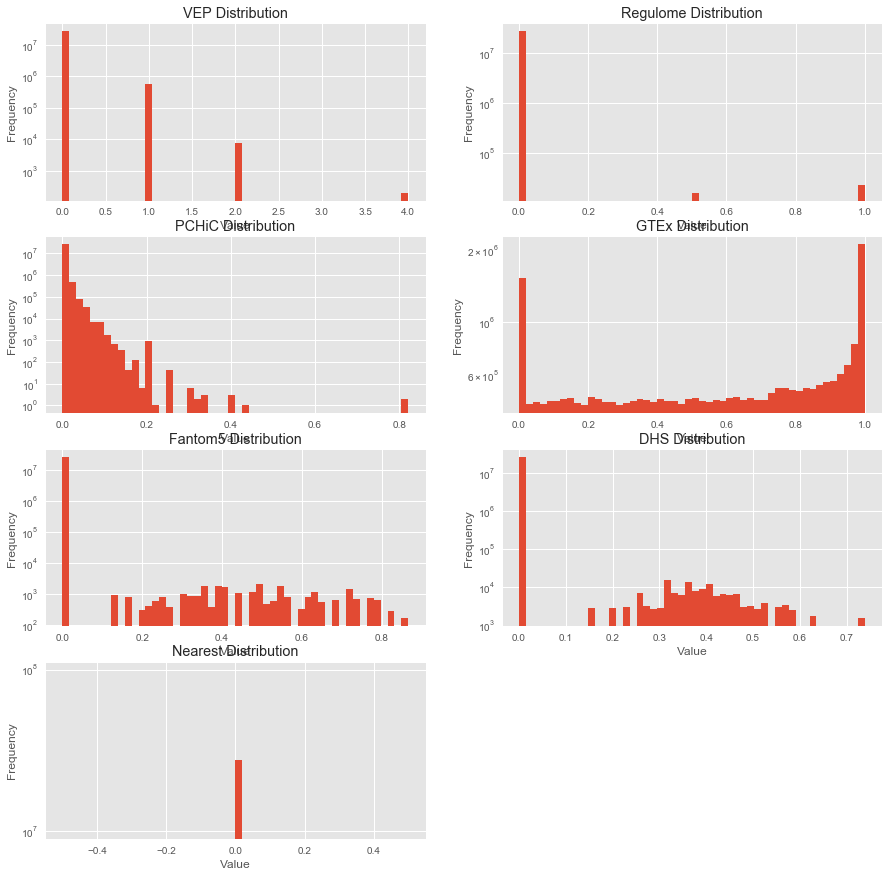

In [42]:
parts = ['VEP', 'Regulome', 'PCHiC', 'GTEx', 'Fantom5', 'DHS', 'Nearest']

# Note: this currently counts across rows for frequency, may also be interested in counts across unique (gene, LD SNP) pairs
plt.figure(figsize=(15, 15))
for (i, p) in enumerate(parts):
    plt.subplot(4, 2, i + 1)
    plt.hist(pg[p], bins=50, log=True)
    plt.title('{} Distribution'.format(p))
    plt.ylabel('Frequency')
    plt.xlabel('Value')

plt.show()

**Question**: For a given (gene, LD SNP) pair, are the score constituents always the same? (I would expect this on the assumption that POSTGAP score is gene-snp centric.)

In [43]:
import itertools
combs = itertools.combinations(parts, 2)
pair = ['gene_id', 'ld_snp_rsID']
unique_counts_per_gene_snp = pg[[*pair, *parts]].groupby(pair).nunique()
unique_count_is_1_across_all_cols = unique_counts_per_gene_snp.apply(lambda x: x == 1).all(axis=1)
# Note: If the answer is yes to the above, would expect unique_count_is_1_across_all_cols to be always true.
# The following (gene, snp) pairs must have at least one constituent part that is multi-valued.
unique_count_is_1_across_all_cols[unique_count_is_1_across_all_cols == False]

gene_id          ld_snp_rsID
ENSG00000005007  rs5827412      False
ENSG00000006015  rs5827412      False
ENSG00000006016  rs5827412      False
ENSG00000007080  rs5827412      False
ENSG00000051128  rs5827412      False
ENSG00000059728  rs11349765     False
                 rs6729760      False
                 rs897119       False
                 rs897120       False
ENSG00000064490  rs5827412      False
ENSG00000064545  rs5827412      False
ENSG00000064607  rs5827412      False
ENSG00000072858  rs2087129      False
ENSG00000087077  rs147130878    False
                 rs73401443     False
                 rs7794485      False
ENSG00000096996  rs5827412      False
ENSG00000099308  rs5827412      False
ENSG00000101138  rs11483285     False
ENSG00000102882  rs11574938     False
ENSG00000103512  rs72774845     False
ENSG00000105639  rs5827412      False
ENSG00000105640  rs5827412      False
ENSG00000105641  rs5827412      False
ENSG00000105643  rs5827412      False
ENSG00000105649  rs58

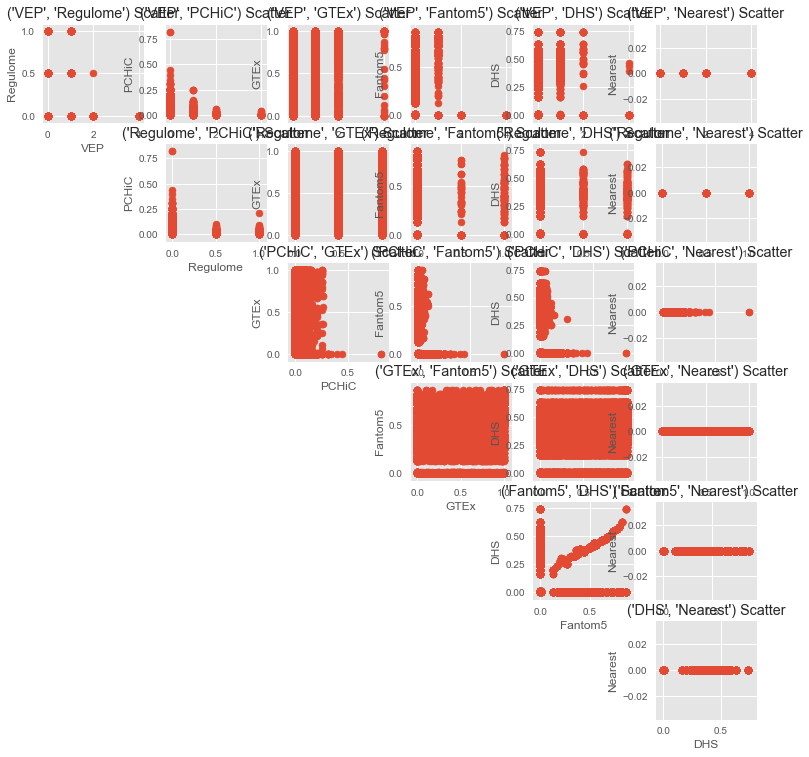

In [44]:
values_per_gene_snp = pg[[*pair, *parts]].groupby(pair).first()
combs = itertools.combinations(parts, 2)

plt.figure(figsize=(15, 15))
for (i, c) in enumerate(combs):
    plt.subplot(7, 7, (parts.index(c[0]) * 7) + parts.index(c[1]) + 1)
    plt.scatter(values_per_gene_snp[c[0]], values_per_gene_snp[c[1]])
    plt.title('{} Scatter'.format(c))
    plt.ylabel('{}'.format(c[1]))
    plt.xlabel('{}'.format(c[0]))

plt.show()

In [45]:
# # quantize
# for (i, p) in enumerate(parts):
#     values_per_gene_snp[p] = values_per_gene_snp[p].apply(lambda x: np.floor(x * 100) / 100)

# plt.figure(figsize=(15, 15))
# for (i, c) in enumerate(combs):
#     plt.subplot(7, 7, (parts.index(c[0]) * 7) + parts.index(c[1]) + 1)
#     grid_values = pd.crosstab(values_per_gene_snp[c[0]], values_per_gene_snp[c[1]])
#     sns.heatmap(grid_values)
#     plt.title('{} Scatter'.format(c))
#     plt.ylabel('{}'.format(c[1]))
#     plt.xlabel('{}'.format(c[0]))

# plt.show()

## Max subscore (as alternative to POSTGAP score)
How is the distribution of `max('VEP', 'Regulome', 'PCHiC', 'GTEx', 'Fantom5', 'DHS', 'Nearest')`? Could this at least be used as a filter, if not as a replacement for POSTGAP score?

In [46]:
pg['max_score'] = pg[['VEP', 'Regulome', 'PCHiC', 'GTEx', 'Fantom5', 'DHS', 'Nearest']].max(axis=1)

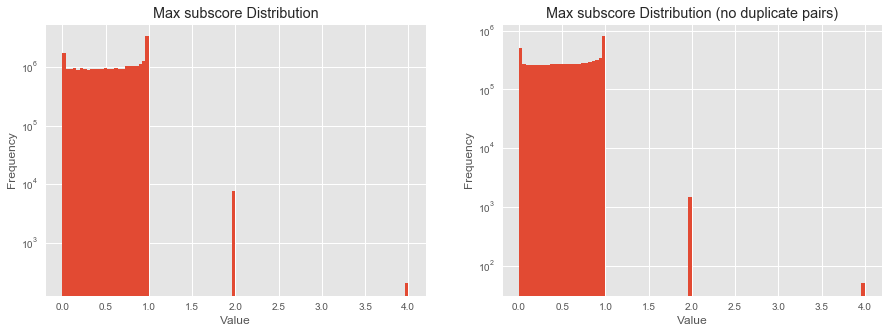

In [47]:
max_score_all = pg['max_score']
# TODO: Check score is the same across all (gene_id, ld_snp_rsID) pairs (to justify use of first())
max_score_no_dupes = pg.groupby(['gene_id', 'ld_snp_rsID'])['max_score'].first()
plot_strength_distribution(max_score_all, max_score_no_dupes, 'Max subscore')

In [48]:
primary_key_groups = pg.groupby(primary_key)
max_scores_per_primary_key_group = primary_key_groups['max_score'].first() # ignore exceptions to uniqueness found above
max_scores = max_scores_per_primary_key_group.reset_index(level=['gwas_snp', 'disease_efo_id', 'gwas_pmid', 'ld_snp_rsID', 'gene_id'])
max_scores.head()

,ld_snp_rsID,gwas_snp,gene_id,disease_efo_id,gwas_pmid,max_score
0,rs10000021,rs936094,ENSG00000052795,EFO_0000220,PMID22076464,0.492369
1,rs10000021,rs936094,ENSG00000109756,EFO_0000220,PMID22076464,0.324204
2,rs10000021,rs936094,ENSG00000164123,EFO_0000220,PMID22076464,0.564575
3,rs10000021,rs936094,ENSG00000164124,EFO_0000220,PMID22076464,0.995720
4,rs10000021,rs936094,ENSG00000164125,EFO_0000220,PMID22076464,0.546565


In [49]:
# merge
max_score_combi_dist = pd.merge(target_counts, max_scores, on=('gwas_snp', 'disease_efo_id', 'gwas_pmid'))

# quantize
max_score_combi_dist['max_score'] = max_score_combi_dist['max_score'].apply(lambda x: np.floor(x * 10) / 10)

# matrixify
max_score_grid = pd.crosstab(max_score_combi_dist['max_score'], max_score_combi_dist['target_count_per_key'])
max_score_grid.head()

target_count_per_key,1,2,3,4,5,6,7,8,9,10,...,121,122,123,126,127,130,131,133,134,152
max_score,,,,,,,,,,,,,,,,,,,,,
0.0,3528,7284,9819,14634,21066,35875,39589,34255,35669,34732,...,7078,1115,612,2156,1021,540,6432,1919,1341,588
0.1,2224,4968,8931,11301,14196,22883,34814,27623,28949,23882,...,4984,758,152,643,168,288,2038,792,228,357
0.2,2674,5083,10163,18499,15339,20278,31575,30519,28197,25111,...,4217,835,214,577,151,373,2498,926,222,492
0.3,2683,5572,8903,17330,15511,22622,37535,26650,26280,25069,...,4979,1196,237,875,146,378,1864,1030,192,399
0.4,2478,4859,8545,14476,16257,24396,43451,25756,26905,25008,...,4385,1340,350,984,155,399,2056,974,231,255


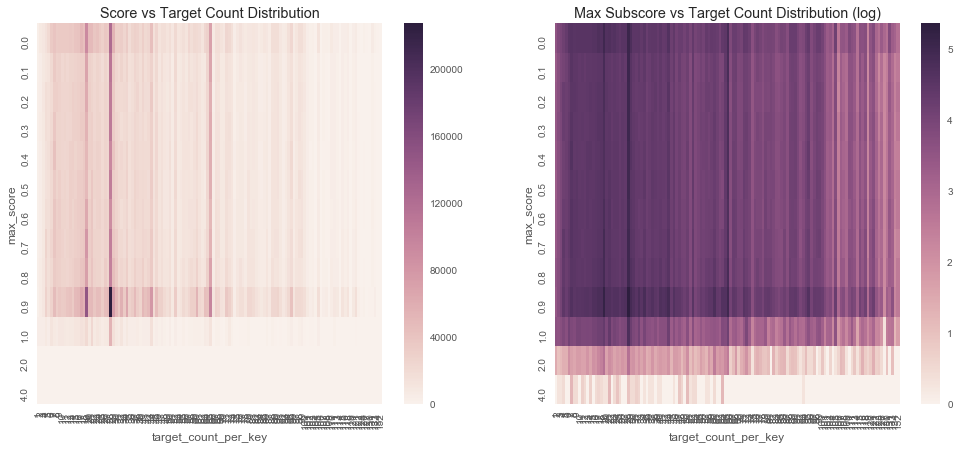

In [50]:
plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)
sns.heatmap(max_score_grid)
plt.title('Score vs Target Count Distribution')

plt.subplot(1, 2, 2)
sns.heatmap(max_score_grid.apply(lambda x: np.log10(x + 1)))
plt.title('Max Subscore vs Target Count Distribution (log)')
plt.show()

In [51]:
# TODO: Investigate
#       * Distribution across chromosomes
#       * Distribution across 1Mbp windows (since this is some sort of cut-off in POSTGAP)
#       * Can we show a gene against ld snp co-occurrence matrix? What about gene against disease?
# .     * More thoughts...?